Dataset from https://www.kaggle.com/paultimothymooney/kermany2018

In [1]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Loading the VGG16 Model

In [2]:
# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the VGG16 model without the top or FC layers
vgg16 = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in vgg16.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


### Let's make a function that returns our FC Head

In [3]:
def addTopModel(bottom_model, num_classes, D=256):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

### Let's add our FC Head back onto VGG

In [4]:
num_classes = 4

FC_Head = addTopModel(vgg16, num_classes)

model = Model(inputs=vgg16.input, outputs=FC_Head)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Loading Retinal Dataset

In [5]:
train_data_dir = 'OCT2017/train'
validation_data_dir = 'OCT2017/test'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
batch_size=16
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 34464 images belonging to 4 classes.
Found 3223 images belonging to 4 classes.


### Training our top layers

In [7]:
checkpoint = ModelCheckpoint("retinal_vgg1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]

In [8]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy'])

In [9]:
nb_train_samples = 34464
nb_validation_samples = 3223

epochs = 10
batch_size = 16

In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
2154/2154 [==============================] - 1081s 502ms/step - loss: 0.9114 - acc: 0.6050 - val_loss: 0.5681 - val_acc: 0.7783

Epoch 00001: val_loss improved from inf to 0.56807, saving model to retinal_vgg1.h5
Epoch 2/10
2154/2154 [==============================] - 577s 268ms/step - loss: 0.7508 - acc: 0.6805 - val_loss: 0.5111 - val_acc: 0.7995

Epoch 00002: val_loss improved from 0.56807 to 0.51110, saving model to retinal_vgg1.h5
Epoch 3/10
2154/2154 [==============================] - 1745s 810ms/step - loss: 0.6947 - acc: 0.7118 - val_loss: 0.5041 - val_acc: 0.7939

Epoch 00003: val_loss improved from 0.51110 to 0.50407, saving model to retinal_vgg1.h5
Epoch 4/10
2154/2154 [==============================] - 2042s 948ms/step - loss: 0.6646 - acc: 0.7288 - val_loss: 0.4447 - val_acc: 0.8291

Epoch 00004: val_loss improved from 0.50407 to 0.44474, saving model to retinal_vgg1.h5
Epoch 5/10
2154/2154 [==============================] - 847s 393ms/step - loss: 0.6626 - acc:

In [11]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

202/202 [==============================] - 22s 110ms/step

Test result: 87.217 loss: 0.374


In [12]:
model.save("retinal_vgg16.h5")

## Confusion Matrix

In [18]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 3223 images belonging to 4 classes.


In [19]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

In [20]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)

In [21]:
y_pred_label = np.argmax(y_pred, axis=1)

In [22]:
validation_generator.classes.shape,y_pred_label.shape

((3223,), (3223,))

In [23]:
#Confusion Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred_label))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Confusion Matrix
[[220   4  18   0]
 [ 34 763  72 130]
 [ 23  14 903  43]
 [  0  23  48 928]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.79      0.91      0.85       242
         DME       0.95      0.76      0.85       999
      DRUSEN       0.87      0.92      0.89       983
      NORMAL       0.84      0.93      0.88       999

   micro avg       0.87      0.87      0.87      3223
   macro avg       0.86      0.88      0.87      3223
weighted avg       0.88      0.87      0.87      3223



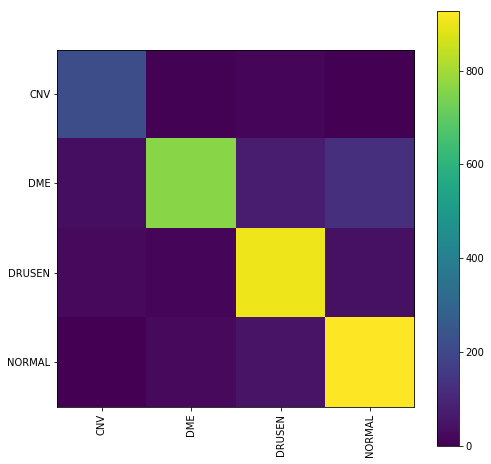

In [24]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
plt.show();

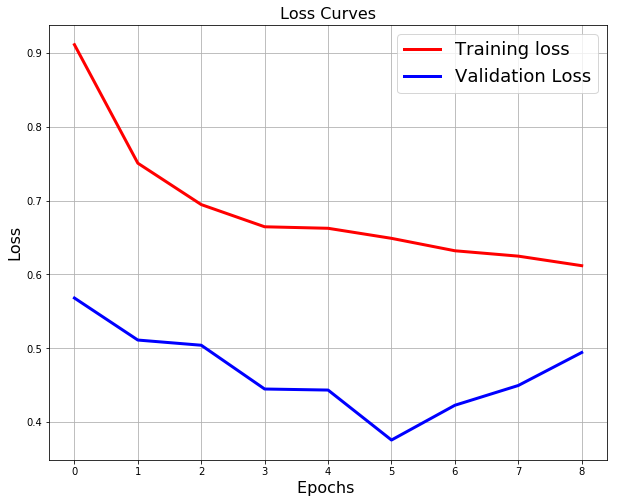

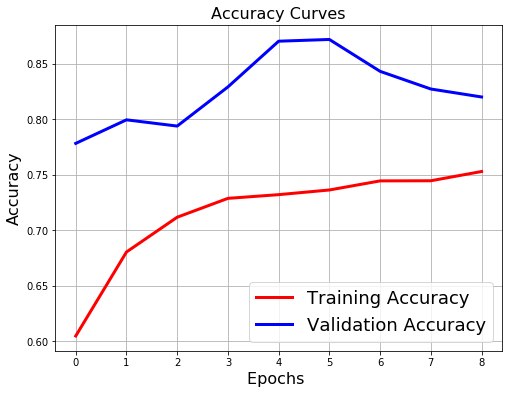

In [25]:
# Loss Curves
plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16);

### Loading our classifer


In [2]:
classifier = load_model("retinal_vgg16.h5")

### Testing on some images

In [3]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

In [4]:
retinal_dict = {"[0]": "CNV", 
                      "[1]": "DME",
                      "[2]": "DRUSEN",
                      "[3]": "NORMAL"}

retinal_dict_n = {"CNV": "CNV ", 
                      "DME": "DME",
                      "DRUSEN": "DRUSEN",
                      "NORMAL": "NORMAL"}

In [5]:
def draw_test(name, pred, im):
    retinal = retinal_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, retinal, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + retinal_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage("OCT2017/val/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()

Class - DRUSEN
Class - CNV 
Class - NORMAL
Class - CNV 
Class - DME
Class - DME
Class - DRUSEN
Class - DRUSEN
Class - DME
Class - DRUSEN


<img src="RetinalVGG16.png">